## Create and test ion channel model

In [25]:
import numpy as np
import pyabc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
import pyabc
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize

In [27]:
from ionchannelABC.visualization import plot_sim_results, plot_experiment_traces

In [28]:
from experiments.whole_cell import ap

In [29]:
from ionchannelABC.experiment import setup

In [30]:
modelfile = 'models/HL1.mmt'

In [31]:
prev_runs = ['ina/hl1_ina.db',
             'ical/hl1_ical.db',
             'icat/hl1_icat.db',
             'iha/hl1_iha.db',
             'ik1/hl1_ik1.db',
             'ikr/hl1_ikr.db',
             'ito/hl1_ito.db',
             'ikss/hl1_ikss.db']
prev_runs = ['sqlite:///results_db/'+path
             for path in prev_runs]

In [32]:
# include uncertainty in membrane capacitance
additional_pars = {'membrane.Cm': pyabc.RV("norm", loc=13.7, scale=(np.sqrt(12)*1.4))}
additional_pars = pyabc.Distribution(additional_pars)

In [33]:
observations, model, summary_statistics = setup(modelfile, ap, 
                                                pacevar='engine.pace',
                                                tvar='phys.T',
                                                logvars=['membrane.V','calcium.Ca_i','engine.time'],
                                                prev_runs=prev_runs,
                                                timeout=5,
                                                additional_pars=additional_pars)

In [34]:
assert(len(observations)==len(summary_statistics(model({}))))

In [35]:
summary_statistics(model({}))

{'0': -1.064963957985613,
 '1': 0.9787793484862166,
 '2': 0.9027651136827574,
 '3': 0.7205740352371885,
 '4': 0.5115432170240931,
 '5': inf,
 '6': inf}

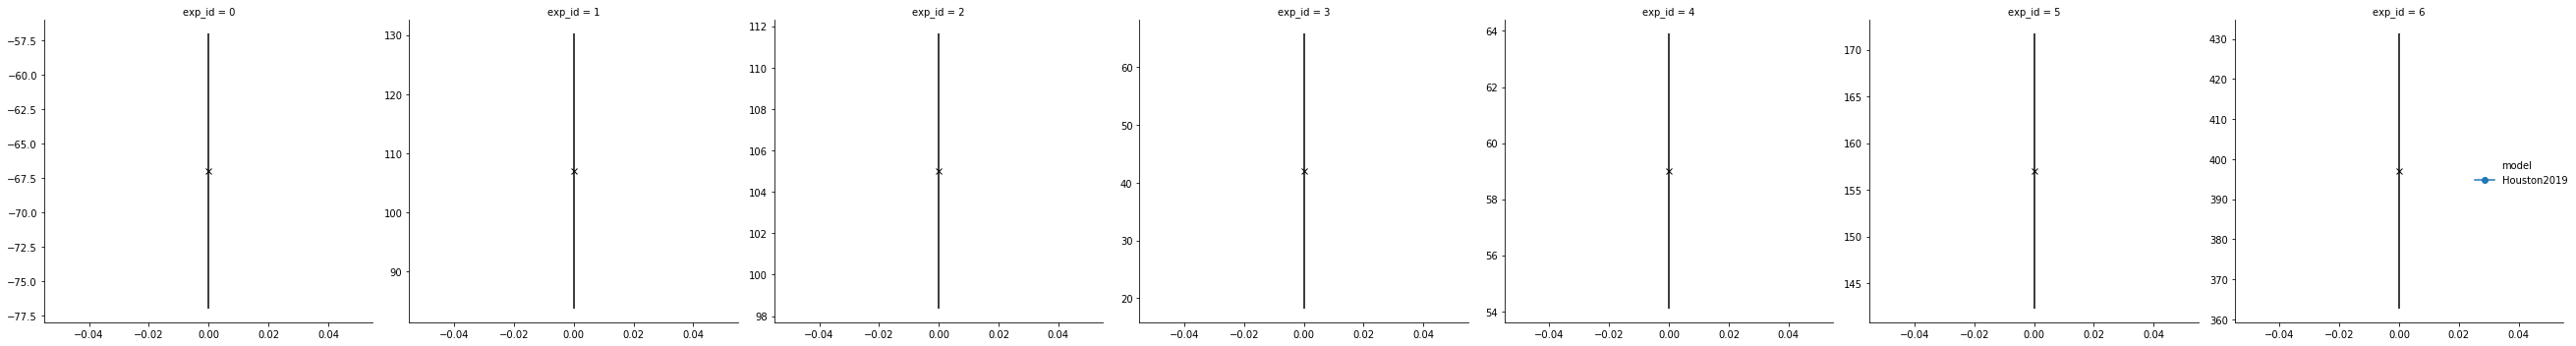

In [12]:
from ionchannelABC import plot_sim_results
g = plot_sim_results(modelfile, ap, 
                     pacevar='engine.pace', 
                     tvar='phys.T', 
                     additional_pars=additional_pars,
                     prev_runs=prev_runs)

## Set limits and generate uniform initial priors

In [36]:
from pyabc import Distribution, RV
limits = {#'cell.V_SR': (0, 0.1), # volume of sarcoplasmic reticulum
          #'log_calcium_sr.Buf_tot': (0, 6.), # calcium buffering in SR (total)
          #'log_calcium_sr.Km_Buf': (0, 3.), # calcium buffering in SR (Km)
          'log_tr.tau_tr': (0, 3.), # time constant for calcium diffusion
          'serca.V_max': (0, 1.), # maximum velocity of SERCA calcium uptake
          'log_leak.k_leak': (-7, -5), # maximum conductance of leak calcium current
          'ryr.k_RyR': (0, 0.1), # maximum conductance of ryanodine receptor current
          #'icab.g_Cab': (0, 0.01), # maximum conductance of background calcium currents
          'inab.g_Nab': (0, 0.01), # maximum conductance of background sodium currents
          'incx.k_NCX': (0, 10), # maximum conductance of Na-Ca exchange current
          'inak.i_NaK_max': (0, 10), # maxmimum conductance of Na-K pump current
          #'ipca.g_pCa': (0, 0.1), # maximum conductance of calcium pump current
          'log_diff.tau_diff': (-3, -1), # cytosolic calcium diffusion coefficient
          #'calcium.D_Ca': (0, 1e2), # cytosolic calcium diffusion coefficient
          #'calcium.Buf_tot': (0, 1e2), # calcium buffering in cytosol
          #'calcium.Km_Buf': (0, 10), # calcium buffer in cytosol (Km)
          #'ical.k_fCass': (0, 10), # steady-state calcium current
         }
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [37]:
summary_statistics(model(prior.rvs()))

{'0': -1.0729324266904068,
 '1': 0.6541735452569473,
 '2': 0.850280543581438,
 '3': 1.0379422756550845,
 '4': 0.5380469096463936,
 '5': 0.5775110538775297,
 '6': 0.393070945097632}

## Run ABC calibration

In [38]:
import os, tempfile
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "whole_cell.db"))

In [15]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [26]:
from ionchannelABC import theoretical_population_size
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 256 particles


In [27]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=10),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.742034919710861, '1': 0.5104332251839483, '2': 1.753123460328047, '3': 0.19534724991847946, '4': 1.3338160267724242, '5': 1.1831023514309071, '6': 1.2821427666553327}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=10, quantile_multiplier=1


In [28]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [29]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-12-05 14:01:22.376555, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=30, min_acceptance_rate=0.001)

INFO:ABC:t: 0, eps: 10.
DEBUG:ABC:Now submitting population 0.
DEBUG:ABC:Population 0 done.
DEBUG:ABC:Total samples up to t = 0: 2437.
INFO:ABC:Acceptance rate: 1000 / 2437 = 4.1034e-01.
DEBUG:Epsilon:new eps, t=1, eps=1.079686861030776
INFO:ABC:t: 1, eps: 1.079686861030776.
DEBUG:ABC:Now submitting population 1.
DEBUG:ABC:Population 1 done.
DEBUG:ABC:Total samples up to t = 1: 6030.
INFO:ABC:Acceptance rate: 1000 / 3593 = 2.7832e-01.
DEBUG:Epsilon:new eps, t=2, eps=0.770215108085734
INFO:ABC:t: 2, eps: 0.770215108085734.
DEBUG:ABC:Now submitting population 2.
DEBUG:ABC:Population 2 done.
DEBUG:ABC:Total samples up to t = 2: 13128.
INFO:ABC:Acceptance rate: 1000 / 7098 = 1.4088e-01.
DEBUG:Epsilon:new eps, t=3, eps=0.6269992007616423
INFO:ABC:t: 3, eps: 0.6269992007616423.
DEBUG:ABC:Now submitting population 3.
DEBUG:ABC:Population 3 done.
DEBUG:ABC:Total samples up to t = 3: 25412.
INFO:ABC:Acceptance rate: 1000 / 12284 = 8.1407e-02.
DEBUG:Epsilon:new eps, t=4, eps=0.5377211890053051
I

In [27]:
abc_continued = ABCSMC(models=model,
                       parameter_priors=prior,
                       distance_function=IonChannelDistance(
                           exp_id=list(observations.exp_id),
                           variance=list(observations.variance),
                           delta=0.05),
                       population_size=ConstantPopulationSize(1000),
                       summary_statistics=summary_statistics,
                       transitions=EfficientMultivariateNormalTransition(),
                       eps=MedianEpsilon(),
                       sampler=MulticoreEvalParallelSampler(n_procs=16),
                       acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.742034919710861, '1': 0.5104332251839483, '2': 1.753123460328047, '3': 0.19534724991847946, '4': 1.3338160267724242, '5': 1.1831023514309071, '6': 1.2821427666553327}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1


In [28]:
abc_continued.load(db_path, 1)

In [ ]:
history = abc_continued.run(minimum_epsilon=0., max_nr_populations=20, min_acceptance_rate=0.0001)

INFO:Epsilon:initial epsilon is 0.3218909654363851
INFO:ABC:t: 13, eps: 0.3218909654363851.
DEBUG:ABC:Now submitting population 13.


# Results analysis

In [39]:
from pyabc import History

In [40]:
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2019-12-05 14:01:22.376555, end_time=2019-12-07 20:45:45.823088)>,
 <ABCSMC(id=2, start_time=2019-12-09 16:10:46.681988, end_time=2019-12-12 11:41:05.695911)>]

In [41]:
df, w = history.get_distribution(m=0)

In [42]:
df.describe()

name,ical.Km_fCa,inab.g_Nab,inak.i_NaK_max,incx.k_NCX,log_diff.tau_diff,log_ical.a_fCa,log_leak.k_leak,log_tr.tau_tr,ryr.k_RyR,serca.V_max
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.746893,0.006105,4.785708,4.750130,-1.521010,-1.701596,-6.007435,1.568827,0.036196,0.375186
std,0.167621,0.002463,2.433871,2.121518,0.480557,0.415031,0.538005,0.802090,0.029995,0.295329
min,0.206364,0.000020,0.007594,0.617259,-2.999200,-2.988913,-6.997365,0.007814,0.000005,0.000333
25%,0.633937,0.004362,2.874985,3.051012,-1.752807,-1.988984,-6.457677,0.931951,0.007920,0.116380
50%,0.779064,0.006507,4.706400,4.505143,-1.356899,-1.679781,-6.006163,1.577957,0.029168,0.299477
75%,0.879898,0.008120,6.629177,6.193464,-1.160536,-1.363716,-5.553964,2.212320,0.062021,0.611449
max,0.999916,0.009987,9.972282,9.995126,-1.000220,-1.000307,-5.004101,2.999036,0.099906,0.999189


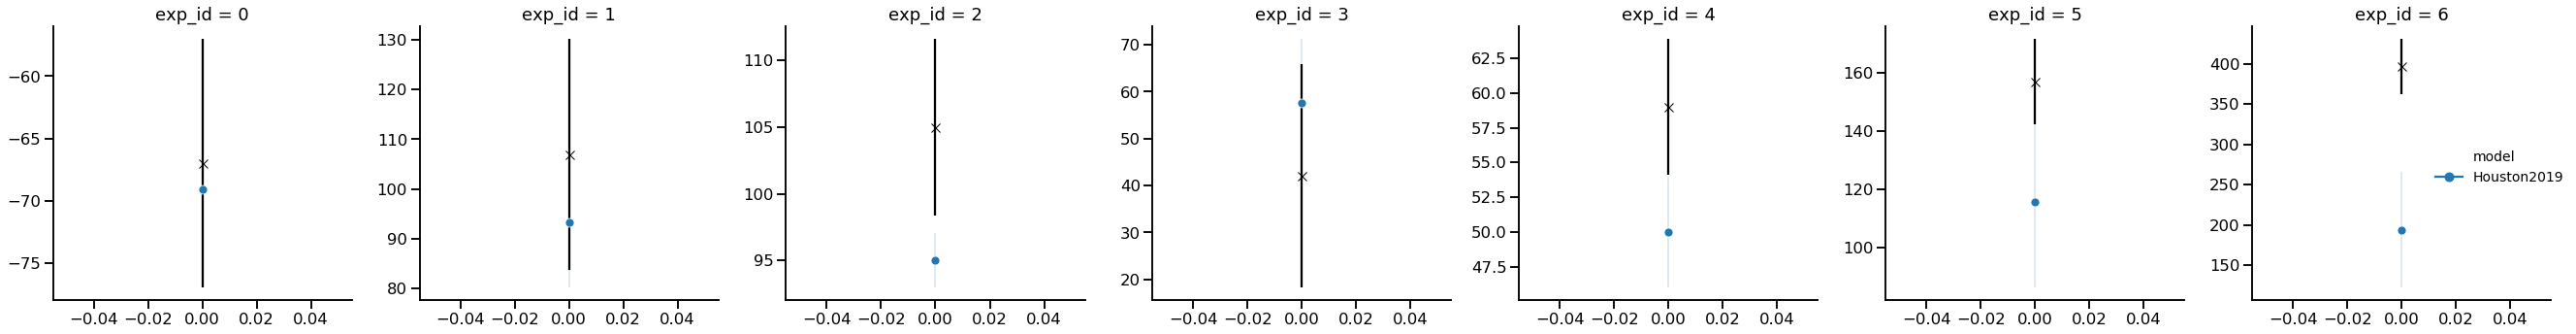

In [43]:
g = plot_sim_results(modelfile, ap, 
                     pacevar='engine.pace', 
                     tvar='phys.T',
                     prev_runs=prev_runs,
                     df=df, w=w,
                     exclude_infs=True)

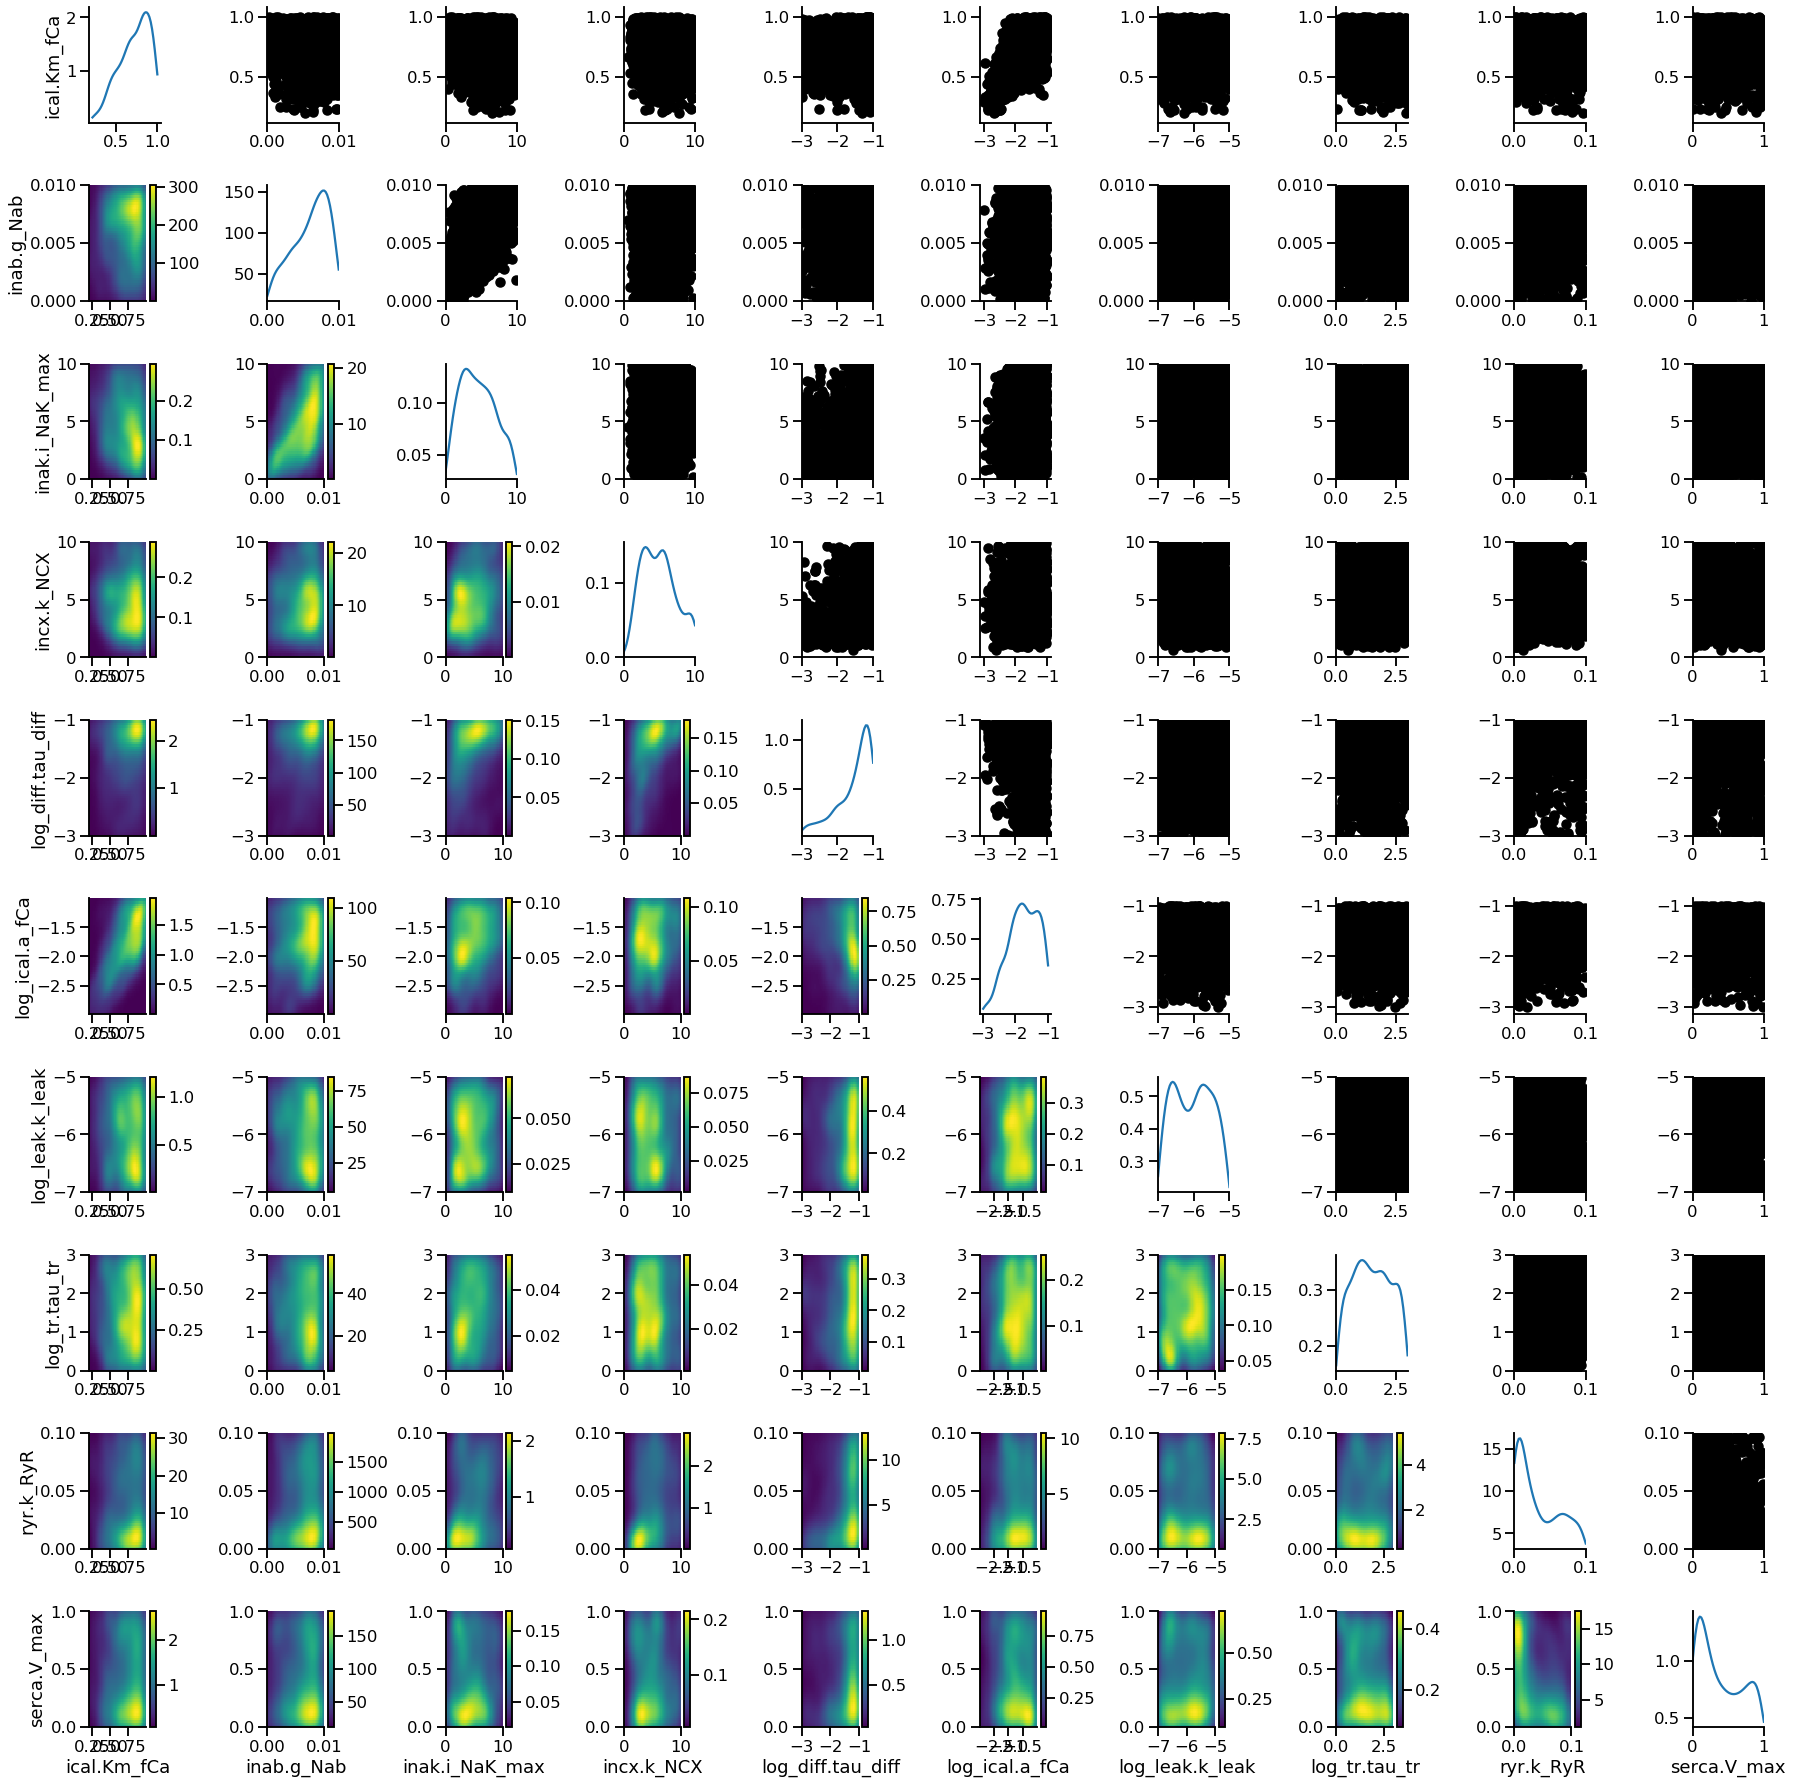

In [44]:
from ionchannelABC.visualization import plot_kde_matrix_custom
g = plot_kde_matrix_custom(df, w, limits=limits)

In [45]:
def split_v(data):
    out = []
    out.append(data.trim(1000*99+975, 1000*100+600, adjust=True))
    return out

In [46]:
recordvars = ['membrane.V', 'calcium.Ca_i', 'calcium.Ca_sub', 'sodium.Na_i', 'potassium.K_i',
              'ical.i_CaL', 'icat.i_CaT', 'ina.i_Na', 'ito.i_to',
              'ikr.i_Kr', 'ikss.i_Kss', 'iha.i_ha', 'ik1.i_k1', 'incx.i_NCX', 'inak.i_NaK']

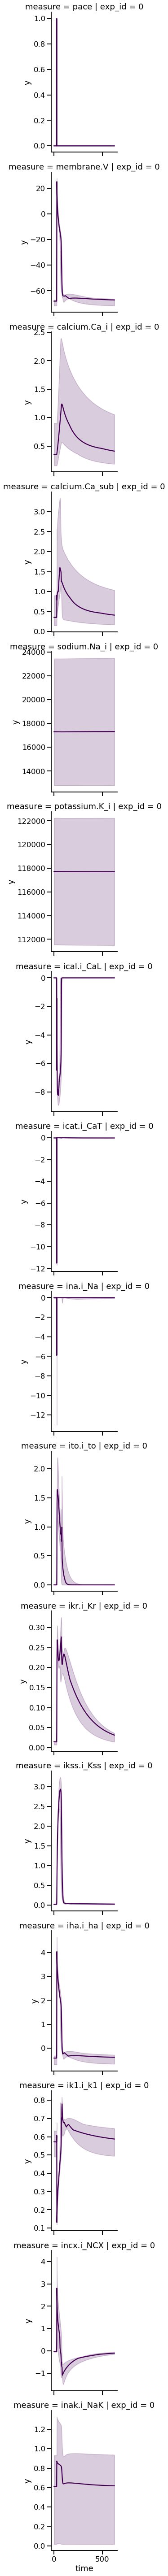

In [47]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_experiment_traces(modelfile, 
                           recordvars,
                           [split_v],
                           ap,
                           pacevar='engine.pace',
                           prev_runs=prev_runs,
                           additional_pars=additional_pars,
                           df=df, w=w, 
                           n_samples=5,
                           log_interval=1,
                           timeout=5,
                           exclude_fails=True)
    
plt.tight_layout()

In [ ]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [ ]:
# Generate sim results samples
import pandas as pd
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    results = summary_statistics(model(th))
    output = pd.DataFrame({'x': observations.x, 'y': list(results.values()),
                           'exp_id': observations.exp_id})
    #output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)